# Team Excitement Ranking

Jacob Crawford

## Introduction

Baseball is a sport with many different teams, and while many fans have a favorite team to watch, some don't. Furthermore, some hardcore fans like to follow as many teams as possible, but only have a limited amount of time to watch baseball. How do we determine which teams are going to provide the most excitement? We will be exploring this idea through a new statistic called the Team Excitement Ranking.


## Calculating TER

In [1]:
from pybaseball.lahman import *
import numpy as np

teams_df = teams()
salaries_df = salaries()

We will start by developing a function that takes in a year and calculates the TER for the end of the season that year. While TER is set up to give a ranking at any point in the season, the dataset we are using (Lahman) provides data at the end of the season. Another restriction due to the dataset is we only have data for the years 2016 and before. 

In [2]:
def get_ter_for_end_of_year(year):
    # Get data from lahman for queried year and 5 years previous
    historical_team_data = teams_df.loc[(teams_df['yearID'] >= (year-5))&(teams_df['yearID'] < year)].copy()
    historical_team_data['attendancePerGame'] = np.ceil(historical_team_data['attendance']/historical_team_data['Ghome'])
    historical_team_data['WSWinBool'] = np.where(historical_team_data['WSWin'] == 'Y', 1, 0)

    # Sum in case a team changes ball parks or something such that they have multiple entries
    historical_team_data = historical_team_data.groupby('teamID', as_index=False).agg({'attendancePerGame': 'sum', 'WSWinBool': 'sum'})
    historical_team_data['avgAttendance'] = np.ceil(historical_team_data['attendancePerGame']/5)

    current_team_data = teams_df.loc[(teams_df['yearID'] == year)]

    historical_and_current = pd.merge(current_team_data, historical_team_data[['teamID', 'avgAttendance', 'WSWinBool']], on='teamID', how='inner')

    # Get num players in top 10% of salaries for current year, add to current year dataframe

    salaries_current_year = salaries_df.loc[(salaries_df['yearID']==year)]

    num_players = len(salaries_current_year)
    ten_percent_amount = int(num_players/10)

    top_ten_percent = salaries_current_year.nlargest(ten_percent_amount, 'salary')
    top_ten_percent_teams = top_ten_percent.groupby('teamID', as_index=False).agg({'salary': 'count'})

    # Combine salary with historical and current data
    all_parameters = pd.merge(historical_and_current, top_ten_percent_teams, on='teamID', how='left')
    all_parameters['salary'].fillna(0, inplace=True)

    # Get ranking for each individual stat
    positive_stats = ['W', 'WSWinBool', 'avgAttendance', 'salary', 'HR', 'SB']

    for stat in positive_stats:
        all_parameters[stat + '_rank'] = all_parameters[stat].rank(ascending=0)

    # Sum the rankings and determine the overall highest based on this value
    all_parameters['total'] = all_parameters['W_rank'] + all_parameters['WSWinBool_rank'] + all_parameters['avgAttendance_rank'] + all_parameters['salary_rank'] + all_parameters['HR_rank'] + all_parameters['SB_rank']
    all_parameters['total_rank'] = all_parameters['total'].rank(ascending=1, method='dense')

    sortedDf = all_parameters.sort_values('total_rank')
    return sortedDf

## Demonstrating TER
We are going to use this function to calculate the TER for 2016. The WSWinBool column is how many world series wins the team has in the last 5 years, avgAttendance is the average attendance of a single home game, and salary is how many players in the top 10% of salary a team has. 

In [3]:
ter_2016 = get_ter_for_end_of_year(2016)
ter_2016[['name', 'total_rank', 'W', 'WSWinBool', 'avgAttendance', 'salary', 'HR', 'SB']]

,name,total_rank,W,WSWinBool,avgAttendance,salary,HR,SB
3,Boston Red Sox,1.0,93,1,36463.0,6.0,208,83.0
27,Texas Rangers,2.0,95,0,36439.0,6.0,215,99.0
9,Detroit Tigers,3.0,86,0,35548.0,7.0,211,58.0
25,St. Louis Cardinals,4.0,86,1,41451.0,0.0,225,35.0
29,Washington Nationals,5.0,95,0,30093.0,0.0,203,121.0
28,Toronto Blue Jays,6.0,89,0,28704.0,3.0,221,54.0
24,San Francisco Giants,7.0,87,2,41471.0,0.0,130,79.0
15,Milwaukee Brewers,8.0,73,0,34010.0,1.0,194,181.0
2,Baltimore Orioles,9.0,89,0,27282.0,5.0,253,19.0
5,Chicago Cubs,10.0,103,0,34852.0,0.0,199,66.0


We will now examine how TER changed between the end of the 2015 season and the end of the 2016 season for each of the teams.

In [4]:
ter_2015 = get_ter_for_end_of_year(2015)
combined = pd.merge(ter_2015[['name', 'total_rank']], ter_2016[['name', 'total_rank']], on='name', how='inner', suffixes=['_2015', '_2016'])
combined['rank_change'] = combined['total_rank_2015'] - combined['total_rank_2016']
combined.sort_values('rank_change', ascending=False)

,name,total_rank_2015,total_rank_2016,rank_change
23,Baltimore Orioles,20.0,9.0,11.0
21,Milwaukee Brewers,18.0,8.0,10.0
11,Detroit Tigers,9.0,3.0,6.0
20,Seattle Mariners,17.0,11.0,6.0
12,Washington Nationals,10.0,5.0,5.0
24,Cleveland Indians,21.0,18.0,3.0
5,Boston Red Sox,4.0,1.0,3.0
0,Texas Rangers,1.0,2.0,-1.0
29,Atlanta Braves,26.0,27.0,-1.0
6,Toronto Blue Jays,5.0,6.0,-1.0


We can see from the above that the Orioles were the team to improve their score the most between 2015 and 2016. Suprisingly, we can also see that the Kansas City Royals lost 7 places, despite their world series win in 2015. This is likely because in order to win a world series, the Royals had to have a good season in 2015, and the stats such as wins or home runs in the calculation are weighted equally with world series wins. Furthermore, because TER is a stat that is relative to your peers, it is possible that they didn't change much, but other teams did.

To give an idea of how much a team's TER can change season to season, below is a visualization of a team's TER over 10 years. To switch the team, copy the name of the team from the above table into the `team_name` variable.

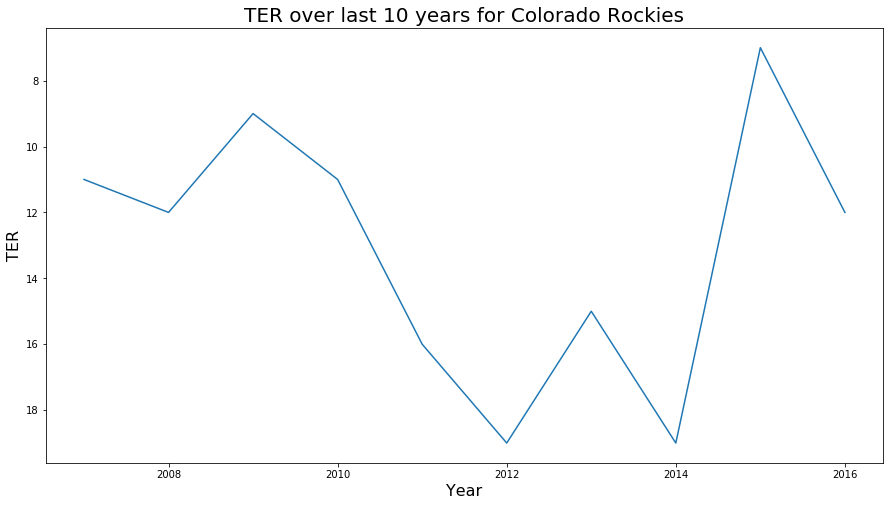

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

# Change this variable to see TER over time for a team
team_name = "Colorado Rockies"

TER_years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
TER_over_time = []

for year in TER_years:
    current_year_TERs = get_ter_for_end_of_year(year)
    team_TER = current_year_TERs.loc[(current_year_TERs['name']==team_name)]['total_rank']
    TER_over_time.append(int(team_TER))
    
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(TER_years, TER_over_time)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("TER", fontsize=16)
ax.set_title("TER over last 10 years for " + team_name, fontsize=20)

# https://stackoverflow.com/a/2052799/2129695 to flip y axis since it is a ranking
ax.set_ylim(ax.get_ylim()[::-1])

temp=0

## Comparing TER to Other Stats

The closest analytical measure of excitement of a team to TER is [NERD](https://blogs.fangraphs.com/nerd-scores-return-with-something-not-unlike-a-vengeance/). This statistic requires a few stats that are not available to pybaseball, and requires you to get data from another data source. Because the focus of this assignment is to flesh out TER and demonstrate its abilities, and not to calculate NERD and practice web scraping, we will be borrowing code from a twitter bot that publishes a team's NERD score whenever they play. All credit for the below function is given to Github user "Metlover" [Github Link](https://github.com/Metlover/NERD-Bot/blob/master/team_nerd_score.py)

### Explanation of and Modifcations to Below Code

Before we move on using this external code, here is a brief summary of what it does, how it calculates NERD, and how I modified it to fit my needs.

1. The first web call queries FanGraphs for Batting Runs Above Average, Home Runs, Total Team Plate Appearances, Baserunning Runs, Defensive Runs and Average Batter Age, and then uses an HTML parser to parse the HTML table into a dataframe.
2. The second web call to FanGraphs is getting pitching data for a team, specifically the Average ERA and the xFIP and parses the HTML into a dataframe.
3. The third web call to spotrac gets the total payroll for a team in a given year. I had to modify the code here to accomodate getting a specific year, as the existing code only works for the current year. This again uses an HTML parser to turn this data into a dataframe.
4. The next web call to FanGraphs is getting WAR and Wins and converts the result to a dataframe.
5. The final call gets park factors for the various stats that need to be park adjusted. These park factors are used in the final calculation.
6. After building up a dataframe, the code calculates NERD based on the equation: zBat + zHR% + zBsR + (zBull / 2) + (zDef / 2) + zPay + zAge + (Luck / 2). It does not appear to add the constant that is mentioned on the FanGraphs site, but does do some scaling to ensure the values are between 0 and 10. The modifications I added here were adding the divide by 2 on the Luck, as FanGraphs calls for it, and adding the constant of 4.0 as specified on FanGraphs.

In [6]:
# Calculate NERD for a team for current year
# !!!!!!!!!!!!!!!!!!!! THIS CODE IS TAKEN FROM THE FOLLOWING SOURCE !!!!!!!!!!!!!!!!!!!! 
# https://github.com/Metlover/NERD-Bot/blob/master/team_nerd_score.py
import requests
from bs4 import BeautifulSoup as bs
import datetime

spotrac_ids = ['Boston Red Sox', 'San Francisco Giants', 'Chicago Cubs',
'Washington Nationals', 'Los Angeles Dodgers',
'Los Angeles Angels of Anaheim', 'New York Yankees', 'Toronto Blue Jays',
'St. Louis Cardinals', 'New York Mets', 'Houston Astros',
'Seattle Mariners', 'Texas Rangers', 'Baltimore Orioles',
'Colorado Rockies', 'Detroit Tigers', 'Cleveland Indians',
'Arizona Diamondbacks', 'Kansas City Royals', 'Minnesota Twins',
'Atlanta Braves', 'Philadelphia Phillies', 'Miami Marlins',
'San Diego Padres', 'Cincinnati Reds', 'Pittsburgh Pirates',
'Milwaukee Brewers', 'Tampa Bay Rays', 'Oakland Athletics',
'Chicago White Sox']

fangraphs_ids = ['Red Sox','Giants','Cubs','Nationals','Dodgers','Angels',
'Yankees','Blue Jays','Cardinals','Mets','Astros','Mariners','Rangers',
'Orioles','Rockies','Tigers','Indians','Diamondbacks','Royals','Twins',
'Braves','Phillies','Marlins','Padres','Reds','Pirates','Brewers','Rays',
'Athletics','White Sox']

def get_nerd_for_end_of_year(year):
    # Add one to the year to accomodate the below code
    year = year+1
    team_url = ('https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=c,53,11,6,111,199,3,58&season=%s&month=0&season1=%s&ind=0&team=0,ts&rost=&age=&filter=&players=0' % (str(year-1),str(year-1)))
    team_page = requests.get(team_url)
    team_soup = bs(team_page.content, 'html.parser')
    table = team_soup.find(lambda tag: tag.name=='table' and tag.has_attr('id') and tag['id']=="LeaderBoard1_dg1_ctl00")
    df = pd.read_html(str(table),header=1)
    df = df[0]
    df = df.iloc[:-1]
    bullpen_url = ('https://www.fangraphs.com/leaders.aspx?pos=all&stats=rel&lg=all&qual=0&type=c,6,62&season=%s&month=0&season1=%s&ind=0&team=0,ts&rost=0&age=0&filter=&players=0' % (str(year-1),str(year-1)))
    bullpen_page = requests.get(bullpen_url)
    bullpen_soup = bs(bullpen_page.content, 'html.parser')
    table = bullpen_soup.find(lambda tag: tag.name=='table' and tag.has_attr('id') and tag['id']=="LeaderBoard1_dg1_ctl00")
    bp_df = pd.read_html(str(table),header=1)
    bp_df = bp_df[0]
    bp_df = bp_df.iloc[:-1]
    df = df.merge(bp_df, on='Team')
    #This part attaches payroll data from SportTrac to the main DF
    payroll_url = 'https://www.spotrac.com/mlb/payroll/' + str(year)
    payroll_page = requests.get(payroll_url)
    payroll_soup = bs(payroll_page.content,'lxml')
    table = payroll_soup.find_all('table')[0]
    pr_df = pd.read_html(str(table),header=0)
    pr_df = pr_df[0]
    pr_df = pr_df.loc[:14].append(pr_df.loc[17:]) #removes annoying "league average" stuff
    for index in range(0,len(spotrac_ids)): #replaces spotrac ids with FanGraphs IDs
        pr_df['Team'].loc[pr_df['Team'] == spotrac_ids[index]] = fangraphs_ids[index]
    df = df.merge(pr_df, on='Team')
    #grabs pitching WAR and Wins to determine team luckiness
    pitch_url = ('https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=c,59,4&season=%s&month=0&season1=%s&ind=0&team=0,ts&rost=0&age=0&filter=&players=0' %  (str(year-1),str(year-1)))
    pitch_page = requests.get(pitch_url)
    pitch_soup = bs(pitch_page.content, 'html.parser')
    table = pitch_soup.find(lambda tag: tag.name=='table' and tag.has_attr('id') and tag['id']=="LeaderBoard1_dg1_ctl00")
    pit_df = pd.read_html(str(table),header=1)
    pit_df = pit_df[0]
    pit_df = pit_df.iloc[:-1]
    df = df.merge(pit_df, on='Team')
    #grabs park factors for adjusting HR rate
    pf_url = ('https://www.fangraphs.com/guts.aspx?type=pf&teamid=0&season=%s' % (str(year-1)))
    pf_page = requests.get(pf_url)
    pf_soup = bs(pf_page.content,'html.parser')
    table = pf_soup.find(lambda tag: tag.name=='table' and tag.has_attr('id') and tag['id']=="GutsBoard1_dg1_ctl00")
    pf_df = pd.read_html(str(table),header=0)
    pf_df = pf_df[0]
    df = df.merge(pf_df, on='Team')
    #calculates NERD
    df['zBat'] = (df['Bat'] - df['Bat'].mean())/df['Bat'].std(ddof=0) #Finds Z-score values for calculation
    df['HRpPA'] = df['HR_x'] / df['PA'] #calculates HR per PA per team
    df['HRpPA'] = df['HRpPA'] * df['HR_y'] / 100 #adjusts for park factors
    df['zHRpPA'] = (df['HRpPA'] - df['HRpPA'].mean())/df['HRpPA'].std(ddof=0)
    df['zBsR'] = (df['BsR'] - df['BsR'].mean())/df['BsR'].std(ddof=0)
    df['zBull'] = -((df['xFIP'] - df['xFIP'].mean())/df['xFIP'].std(ddof=0))
    df['zDef'] = (df['Def'] - df['Def'].mean())/df['Def'].std(ddof=0)
    df[str(year) + ' Total Payroll'] = df[str(year) + ' Total Payroll'].replace('[\$,]', '', regex=True).astype(float) #converts dollar amounts to numbers
    df['zPay'] = -((df[str(year) + ' Total Payroll'] - df[str(year) + ' Total Payroll'].mean())/df[str(year) + ' Total Payroll'].std(ddof=0))
    df['zAge'] = -((df['Age'] - df['Age'].mean())/df['Age'].std(ddof=0))
    df['tWAR'] = df['WAR_x'] + df['WAR_y']
    df['Luck'] = (df['tWAR'] - df['W'])/20 #Adjusted for calculation
    df['zPay'][df['zPay'] < 0] = 0 #replaces values. These throw warnings for no reason because Pandas can't act like R without throwing a goddamn fit
    df['zAge'][df['zAge'] < 0] = 0
    df['Luck'][df['Luck'] < 0] = 0
    df['Luck'][df['Luck'] > 2] = 2
    df['NERD'] = df['zBat'] + df['zHRpPA'] + df['zBsR'] + (df['zBull'] / 2) + (df['zDef'] / 2) + df['zPay'] + df['zAge'] + (df['Luck']/2) + 4.0 #unadjusted NERD
    df['NERD'] = (((df['NERD'] - min(list(df['NERD']))) * (10)) / (max(list(df['NERD'])) - min(list(df['NERD'])))) #feature scaled
    
    # This chunk of code is further modifications to manipulate the dataframe as I need it
    sortedDf = df.sort_values('NERD', ascending=False)
    for index in range(0,len(spotrac_ids)): #replaces FanGraphs IDs with spotrac ids
        sortedDf['Team'].loc[sortedDf['Team'] == fangraphs_ids[index]] = spotrac_ids[index]
    
    sortedDf['NERD_rank'] = sortedDf['NERD'].rank(ascending=False, method='dense')
    return sortedDf[['Team', 'NERD', 'NERD_rank']]

In [7]:
NERD_2016 = get_nerd_for_end_of_year(2016)
NERD_2016

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be s

,Team,NERD,NERD_rank
2,Chicago Cubs,10.000000,1.0
0,Boston Red Sox,8.680795,2.0
14,Houston Astros,8.166261,3.0
7,Baltimore Orioles,7.732256,4.0
6,Cleveland Indians,7.604102,5.0
11,Arizona Diamondbacks,7.436221,6.0
10,Washington Nationals,7.359993,7.0
27,San Diego Padres,7.145416,8.0
1,Colorado Rockies,6.771278,9.0
13,Minnesota Twins,6.428452,10.0


Above we have how NERD ranks the teams. Let's dive in deeper and see how the rankings compare.

In [8]:
combined = pd.merge(NERD_2016, ter_2016[['name', 'total_rank']], left_on='Team', right_on='name', how='right')
combined['rank_difference'] = np.abs(combined['total_rank'] - combined['NERD_rank'])
combined.sort_values('rank_difference', ascending=False)

,Team,NERD,NERD_rank,name,total_rank,rank_difference
25,San Francisco Giants,2.430342,26.0,San Francisco Giants,7.0,19.0
20,Detroit Tigers,4.135624,21.0,Detroit Tigers,3.0,18.0
18,Texas Rangers,4.875274,19.0,Texas Rangers,2.0,17.0
7,San Diego Padres,7.145416,8.0,San Diego Padres,24.0,16.0
10,Tampa Bay Rays,6.314441,11.0,Tampa Bay Rays,26.0,15.0
17,St. Louis Cardinals,5.073650,18.0,St. Louis Cardinals,4.0,14.0
2,Houston Astros,8.166261,3.0,Houston Astros,16.0,13.0
4,Cleveland Indians,7.604102,5.0,Cleveland Indians,18.0,13.0
5,Arizona Diamondbacks,7.436221,6.0,Arizona Diamondbacks,19.0,13.0
0,Chicago Cubs,10.000000,1.0,Chicago Cubs,10.0,9.0


We can see from the above that there is a pretty significant spread here between the two stats. For some teams such as the Phillies, the ranks are exactly the same, whereas for others like the Giants, the rankings are 19 places apart. Let's further follow this up by getting a correlation coefficient between the two rankings.

In [9]:
combined[['NERD_rank', 'total_rank']].corr()

,NERD_rank,total_rank
NERD_rank,1.000000,0.348906
total_rank,0.348906,1.000000


Our correlation between the two columns is about .349. We can conclude from this that there is a bit of positive correlation between the two stats, but not a ton. 

## Further Demonstration

Below, feel free to change the year parameter in the function call to get the TER for that year. Remember that due to dataset constraints, this gives the TER for the end of the year given, and the latest year that can be entered without erroring is 2016.

In [19]:
user_selected_year = get_ter_for_end_of_year(2003)

user_selected_year[['name', 'total_rank', 'W', 'WSWinBool', 'avgAttendance', 'salary', 'HR', 'SB']]

,name,total_rank,W,WSWinBool,avgAttendance,salary,HR,SB
18,New York Yankees,1.0,101,3,39893.0,9.0,230,98.0
2,Atlanta Braves,2.0,101,0,37796.0,6.0,235,68.0
4,Boston Red Sox,3.0,95,0,31169.0,4.0,238,88.0
26,St. Louis Cardinals,4.0,85,0,39118.0,3.0,196,82.0
24,Seattle Mariners,5.0,93,0,38353.0,3.0,139,108.0
0,Anaheim Angels,6.0,77,1,27522.0,4.0,150,129.0
1,Arizona Diamondbacks,7.0,84,1,38291.0,3.0,152,76.0
12,Houston Astros,8.0,87,0,33604.0,4.0,191,66.0
6,Chicago Cubs,9.0,88,0,34003.0,3.0,172,73.0
9,Colorado Rockies,9.0,74,0,40676.0,3.0,198,63.0
